In [1]:
# import packages
from pyproj import CRS, Transformer
import h5py
import glob
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cmocean
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [2]:
# define data and script directory (replace with your file path)
data_dir = '/Volumes/Extreme SSD/data/'
script_dir = '/Users/Wilson/Documents/0-code/scripts'

In [3]:
# define utility functions

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def read_field(group, field):
    """
    generic field-reading function
    """
    data=np.array(group[field])
    bad=(data==group[field].attrs['_FillValue'])
    data[bad]=np.NaN
    return data

def read_ATL11(filename, pair):
    """
    ATL11 reader
    """
    with h5py.File(filename,'r') as h5f:
        longitude=read_field(h5f[pair],'longitude')
        latitude=read_field(h5f[pair],'latitude')
        h_corr=read_field(h5f[pair],'h_corr')
        h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
        h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
        quality=np.array(h5f[pair]['quality_summary'])
    for col in range(h_corr.shape[1]):
        h_corr[quality==1]=np.NaN
    # return the values
    return longitude, latitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

In [4]:
# grab ATL11 files
#files=glob.glob(data_dir + '/ATL11.004-Ant/*.h5')
files=glob.glob(data_dir + '/altimetry/ICESat-2/ATL11.005-Ant/*h5')

# create empty lists
lon=[]
lat=[]
h_corr=[]
sigma_h=[]

# fill lists
for file in files:
    try:
        for pair in ['pt1','pt2','pt3']:
            lons, lats, hh, ss=read_ATL11(file, pair)
            lon += [lons]
            lat += [lats]
            h_corr += [hh]
            sigma_h += [ss]
    except Exception as E:
        pass

# concatenate lists
lon=np.concatenate(lon)
lat=np.concatenate(lat)
h_corr=np.concatenate(h_corr, axis=0)
sigma_h=np.concatenate(sigma_h, axis=0)
x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

# define time based on orbital cycles every quarter year
t = np.linspace(2019.25, 2019.25+(len(h_corr[0,:])-1)*0.25, len(h_corr[0,:]))

In [5]:
# import subglacial lake outlines 
outlines = open(script_dir + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(script_dir + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

# drop outlines from SiegfiedFricker2018_outlines that are duplicative of Smith2009_outlines
SiegfriedFricker2018_newoutlines = SiegfriedFricker2018_outlines.copy(deep=True)
SiegfriedFricker2018_newoutlines.drop(SiegfriedFricker2018_newoutlines.loc[SiegfriedFricker2018_newoutlines['cite'].str.contains('Smith and others, 2009')].index, inplace=True)

In [6]:
# define bounding box of interest in polar stereographic coordinates
# (here Slessor23, East Antarctica)
x_min = -4.25e5
x_max = -3.9e5
y_min = 1.015e6
y_max = 1.05e6

# subset x, y, h_corr to xy bounding box for faster plotting
x_sub=x[(x>=x_min)*(x<=x_max)*(y>=y_min)*(y<=y_max)] 
y_sub=y[(x>=x_min)*(x<=x_max)*(y>=y_min)*(y<=y_max)]
h_sub=h_corr[(x>=x_min)*(x<=x_max)*(y>=y_min)*(y<=y_max),:] 

In [7]:
# estabish variables
x = x_sub
y = y_sub
z = h_sub[:,2]-h_sub[:,1]
# remove nan's
x = x[np.logical_not(np.isnan(z))]
y = y[np.logical_not(np.isnan(z))]
z = z[np.logical_not(np.isnan(z))]

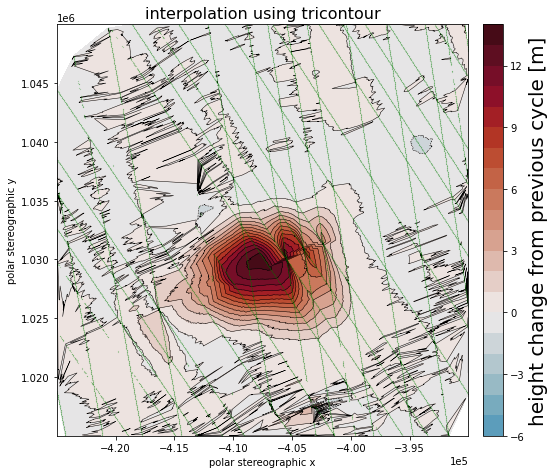

In [8]:
# https://matplotlib.org/3.3.0/gallery/images_contours_and_fields/irregulardatagrid.html
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# plot interpolated chloropleth map of surface deformation
fig, ax = plt.subplots(figsize=(8,8))
cntr = ax.tricontourf(x, y, z, cmap=cmocean.cm.balance, levels=20, norm=colors.CenteredNorm())
ax.tricontour(x, y, z, linewidths=0.5, colors='k', levels=20)
ax.ticklabel_format(axis='both',scilimits=(0,0))
ax.set_aspect('equal')
ax.plot(x, y, 'go', ms=0.1)
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
ax.set_xlabel('polar stereographic x')
ax.set_ylabel('polar stereographic y')
ax.set_title('interpolation using tricontour', size=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(cntr, cax=cax).set_label('height change from previous cycle [m]', size=20)
plt.show()

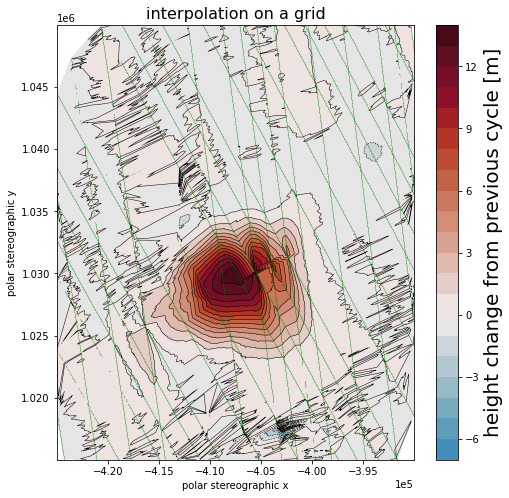

In [170]:
# https://matplotlib.org/3.3.0/gallery/images_contours_and_fields/irregulardatagrid.html
# -----------------------
# Interpolation on a grid
# -----------------------
# A contour plot of irregularly spaced data coordinates
# via interpolation on a grid.

# Create grid values first.
ngridx = ngridy = 1000
# upsample evenly along x and y axis
xi = np.linspace(x.min(), x.max(), ngridx)
yi = np.linspace(y.min(), y.max(), ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

fig, ax = plt.subplots(figsize=(8,8))
ax.contour(xi, yi, zi, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, zi, levels=20, cmap=cmocean.cm.balance, norm=colors.CenteredNorm())
fig.colorbar(cntr, ax=ax).set_label('height change from previous cycle [m]', size=20)
ax1.set_aspect('equal')
ax.plot(x, y, 'go', ms=0.1)
ax.ticklabel_format(axis='both',scilimits=(0,0))
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
ax.set_title('interpolation on a grid', size=16)
ax.set_xlabel('polar stereographic x')
ax.set_ylabel('polar stereographic y')
plt.show()

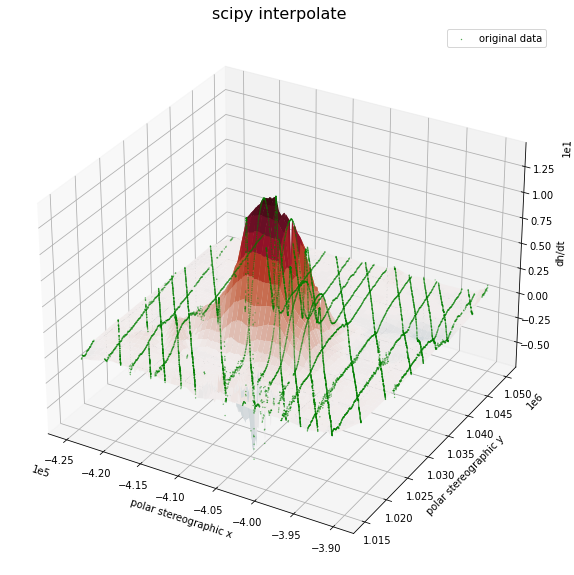

In [171]:
# https://matplotlib.org/3.3.0/gallery/images_contours_and_fields/irregulardatagrid.html
# -----------------------
# scipy interpolate griddata
# -----------------------
# Note that scipy.interpolate provides means to interpolate data on a grid
# as well. The following would be an alternative to the four lines above:
# from scipy.interpolate import griddata
#zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")

# number of data points per axis
n = 1000
# upsample evenly along x and y axis
x_up = np.linspace(np.min(x), np.max(x), n)
y_up = np.linspace(np.min(y), np.max(y), n)

# create grid from these updsampled 1D arrays
x3d, y3d = np.meshgrid(x_up, y_up)
# interpolate z-values for this regular grid
# x, y, z are your original data points
# methods other than cubic are available
z3d = griddata((x, y), z, (x3d, y3d), method = 'linear')
#plot surface
ax.plot_surface(x3d, y3d, z3d, cmap=cmocean.cm.balance, norm=colors.CenteredNorm())
#plot original data points on top
ax.scatter(x, y, z, color = "g", marker = "o", s = 0.1, label='original data')
ax.ticklabel_format(axis='both',scilimits=(0,0))
ax.set_title('scipy interpolate', size=16)
ax.set_xlabel('polar stereographic x')
ax.set_ylabel('polar stereographic y')
ax.set_zlabel('dh/dt')
ax.legend()
plt.show()

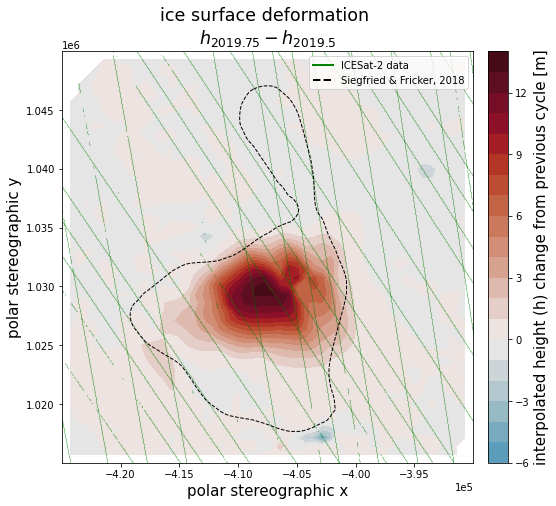

In [202]:
# https://matplotlib.org/3.3.0/gallery/images_contours_and_fields/irregulardatagrid.html
# -----------------------
# scipy interpolate griddata
# -----------------------
# Note that scipy.interpolate provides means to interpolate data on a grid
# as well. The following would be an alternative to the four lines above:
# from scipy.interpolate import griddata
#zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

# number of data points per axis
n = 50
# upsample evenly along x and y axis
xi = np.linspace(np.min(x), np.max(x), n)
yi = np.linspace(np.min(y), np.max(y), n)

# create grid from these updsampled 1D arrays
Xi, Yi = np.meshgrid(xi, yi)
# interpolate z-values for this regular grid
# x, y, z are your original data points
# methods other than cubic are available
zi = griddata((x, y), z, (Xi, Yi), method = 'linear')

fig, ax = plt.subplots(figsize=(8,8))
#ax.contour(xi, yi, zi, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi, yi, zi, levels=20, cmap=cmocean.cm.balance, norm=colors.CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(cntr, cax=cax).set_label('interpolated height (h) change from previous cycle [m]', size=15)
ax.set_aspect('equal')
ax.plot(x, y, 'go', ms=0.1)
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
ax.ticklabel_format(axis='both',scilimits=(0,0))
ax.set_title('ice surface deformation \n$h_{2019.75} - h_{2019.5}$', pad=7.5, fontsize=17.5)
ax.set_xlabel('polar stereographic x', size=15)
ax.set_ylabel('polar stereographic y', size=15)
outlines_gdf.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
IS2 = plt.Line2D((0, 1), (0, 0), color='g', linestyle='-', linewidth=2)
Siegfried2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
ax.legend([IS2, Siegfried2018],
           ['ICESat-2 data', 'Siegfried & Fricker, 2018'], loc='upper right')#, 'Smith and others, 2009'])
plt.show()

In [199]:
# export interpolated ice surface deformation data to csv
np.savetxt("slessor23.csv", zi, delimiter=",")

In [203]:
# import interpolated ice surface deformation csv into numpy array
my_data = np.genfromtxt('slessor23.csv', delimiter=',')

In [ ]:
# use for loop to create contour maps for each cycle, export as csv's
for idx in len(h_sub[0,:])

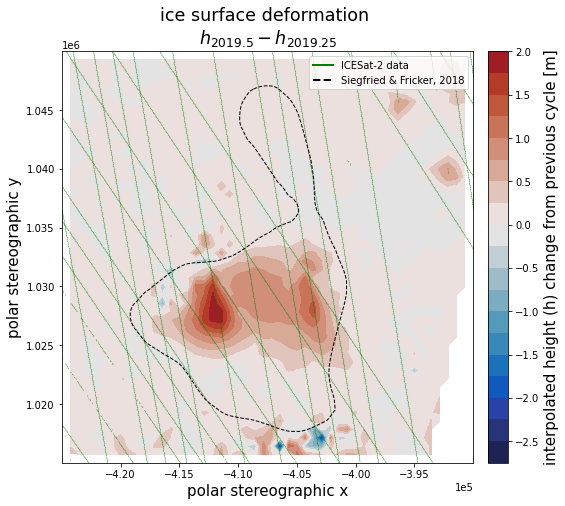

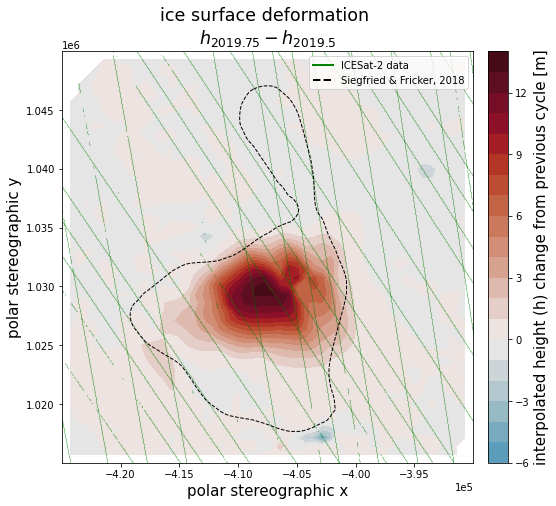

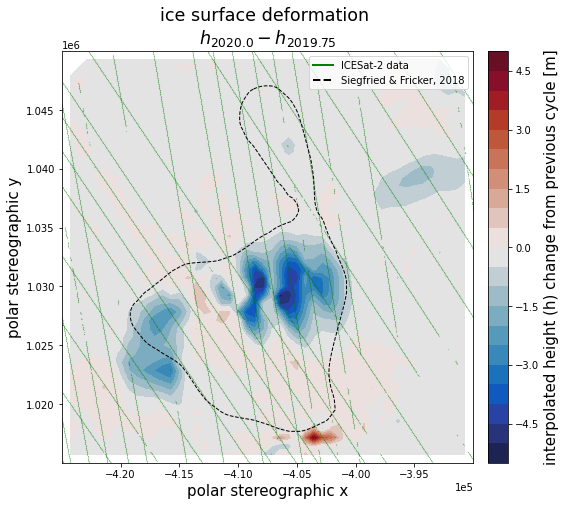

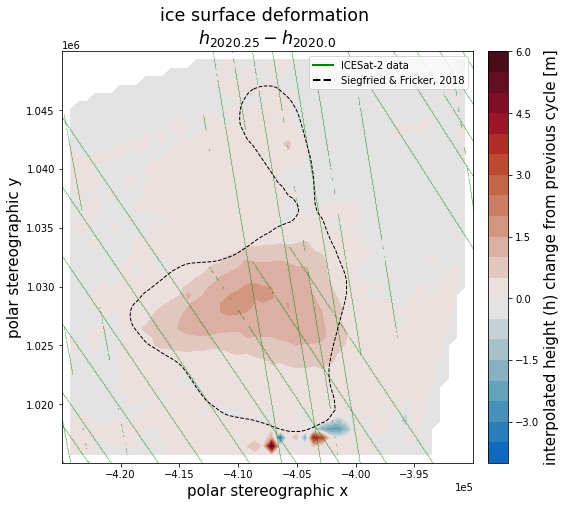

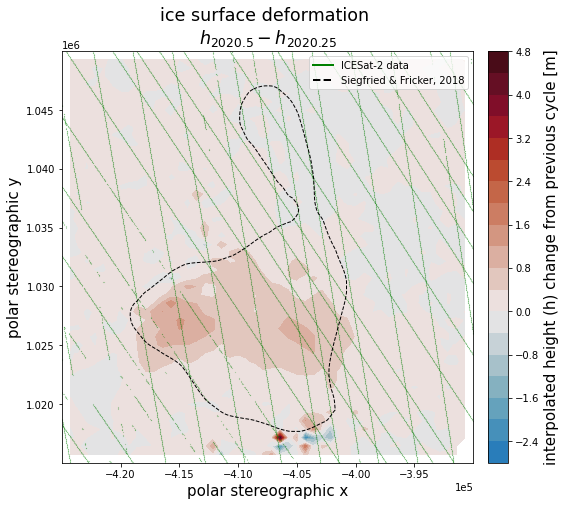

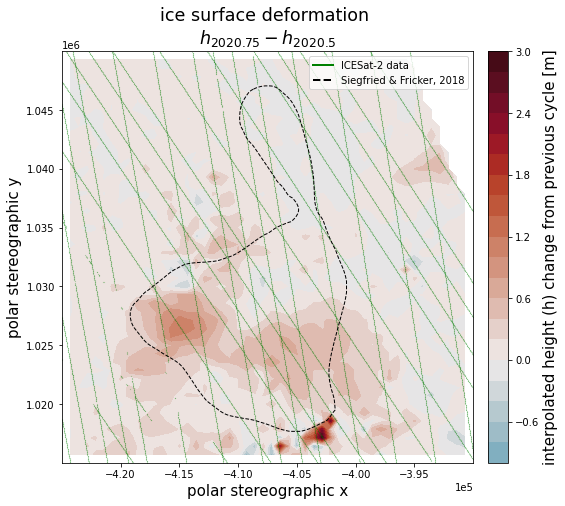

In [75]:
for idx in range(len(h_sub[0,:])-1):
    
    # estabish variables
    x = x_sub
    y = y_sub
    z = h_sub[:,idx+1]-h_sub[:,idx]
    # remove nan's
    x = x[np.logical_not(np.isnan(z))]
    y = y[np.logical_not(np.isnan(z))]
    z = z[np.logical_not(np.isnan(z))]

    # number of data points per axis
    n = 50
    # upsample evenly along x and y axis
    xi = np.linspace(np.min(x), np.max(x), n)
    yi = np.linspace(np.min(y), np.max(y), n)

    # create grid from these updsampled 1D arrays
    Xi, Yi = np.meshgrid(xi, yi)
    # interpolate z-values for this regular grid
    # x, y, z are your original data points
    # methods other than cubic are available
    zi = griddata((x, y), z, (Xi, Yi), method = 'linear')

    fig, ax = plt.subplots(figsize=(8,8))
    cntr = ax.contourf(xi, yi, zi, levels=20, cmap=cmocean.cm.balance, norm=colors.CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(cntr, cax=cax).set_label('interpolated height (h) change from previous cycle [m]', size=15)
    ax.set_aspect('equal')
    ax.plot(x, y, 'go', ms=0.1)
    ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
    ax.ticklabel_format(axis='both',scilimits=(0,0))
    ax.set_title('ice surface deformation \n$h_{'+str(t[idx+1])+'} - h_{'+str(t[idx])+'}$', pad=7.5, fontsize=17.5)
    ax.set_xlabel('polar stereographic x', size=15)
    ax.set_ylabel('polar stereographic y', size=15)
    outlines_gdf.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
    IS2 = plt.Line2D((0, 1), (0, 0), color='g', linestyle='-', linewidth=2)
    Siegfried2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
    ax.legend([IS2, Siegfried2018],
               ['ICESat-2 data', 'Siegfried & Fricker, 2018'], loc='upper right')#, 'Smith and others, 2009'])
    plt.savefig('slessor23_cyc'+str(t[idx]+0.25)+'-'+str(t[idx])+'.png')
    plt.show()
    # export interpolated ice surface deformation data to csv
    np.savetxt('slessor23_'+str(t[idx]+0.25)+'-'+str(t[idx])+'.csv', zi, delimiter=",")

In [130]:
# find number of csv files in working directory
# add data_dir in arguments if stored elsewhere
files=glob.glob('*.csv')
# define time based on orbital cycles every quarter year
t = np.linspace(2019.25, 2019.25+(len(files))*0.25, len(files)+1)

In [131]:
# import interpolated ice surface deformation csv's into numpy array
arrays = [np.genfromtxt('slessor23_'+str(t[idx+1])+'-'+str(t[idx])+'.csv', delimiter=',') for idx in range(len(files))]
np.stack(arrays, axis=0).shape

(6, 50, 50)